pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
Episode 0, Total Reward: 1, Average Loss: 0.0020855511721274843
Episode 1, Total Reward: 0, Average Loss: 0.004872303276221958
Episode 2, Total Reward: 0, Average Loss: 0.00389538202886927
Episode 3, Total Reward: 0, Average Loss: 0.0040936080842757724
Episode 4, Total Reward: 0, Average Loss: 0.004014136187953184
Episode 5, Total Reward: 0, Average Loss: 0.004136827891258171
Episode 6, Total Reward: 0, Average Loss: 0.004132744938546498
Episode 7, Total Reward: 0, Average Loss: 0.0044245491550511705
Episode 8, Total Reward: 0, Average Loss: 0.003415747643503848
Episode 9, Total Reward: 0, Average Loss: 0.0037282250472387766
Episode 10, Total Reward: 0, Average Loss: 0.004185418200471585
Episode 11, Total Reward: 0, Average Loss: 0.004044926239236615
Episode 12, Total Reward: 0, Average Loss: 0.0025021228683196266
Episode 13, Total Reward: 0, Average Loss: 0.002994470402221

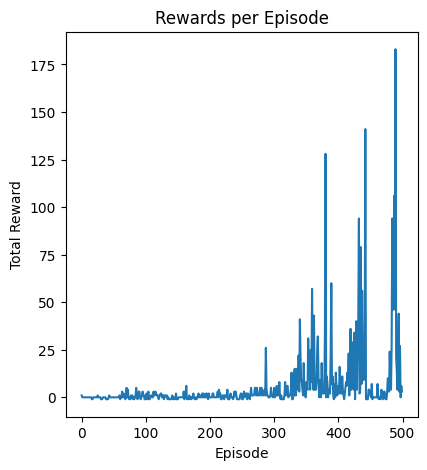

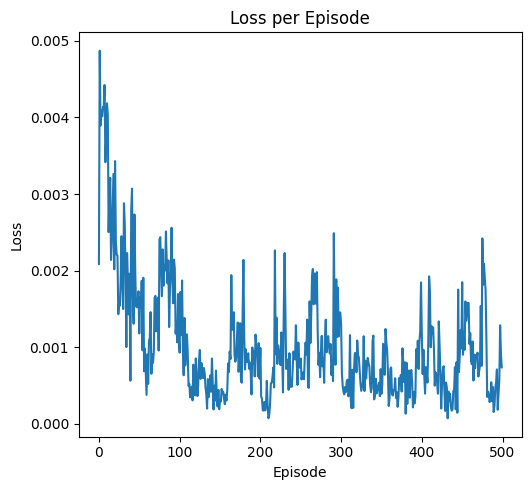

In [1]:
import random
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pygame


pygame.init()

class PongEnvironment:
    def __init__(self, width=400, height=300):
        self.width = width
        self.height = height
        self.ball_radius = 10
        self.paddle_width = 10
        self.paddle_height = 60
        self.paddle_offset = 20
        self.ball_pos = np.array([self.width // 2, self.height // 2], dtype=float)
        self.ball_vel = np.array([0.03, 0.01], dtype=float) * 100
        self.paddle_pos = self.height // 2
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Pong")

    def reset(self):
        self.ball_pos = np.array([self.width // 2, self.height // 2], dtype=float)
        self.ball_vel = np.array([0.03, 0.01], dtype=float) * 100
        self.paddle_pos = self.height // 2
        return torch.FloatTensor(self.get_state())

    def step(self, action):
        if action == 0:  # Move up
            move = -5
        else:  # Move down
            move = 5
        self.move_paddle(move)
        self.ball_pos += self.ball_vel

        if self.ball_pos[1] <= self.ball_radius or self.ball_pos[1] >= self.height - self.ball_radius:
            self.ball_vel[1] *= -1

        reward = 0
        done = False

        if self.ball_pos[0] <= self.paddle_width + self.ball_radius:
            if self.paddle_pos - self.paddle_height / 2 <= self.ball_pos[1] <= self.paddle_pos + self.paddle_height / 2:
                self.ball_vel[0] *= -1
                reward = 1
            else:
                reward = -1
                done = True

        if self.ball_pos[0] >= self.width - self.ball_radius - self.paddle_width:
            self.ball_vel[0] *= -1

        return torch.FloatTensor(self.get_state()), reward, done  # Return state as a tensor

    def move_paddle(self, move):
        self.paddle_pos = np.clip(self.paddle_pos + move, self.paddle_height / 2, self.height - self.paddle_height / 2)

    def get_state(self):
        return np.array([
            self.ball_pos[0] / self.width,
            self.ball_pos[1] / self.height,
            self.ball_vel[0] / 100,
            self.ball_vel[1] / 100,
            self.paddle_pos / self.height
        ])

    def render(self):
        self.screen.fill((0, 0, 0))
        pygame.draw.rect(self.screen, (255, 255, 255), pygame.Rect(0, int(self.paddle_pos - self.paddle_height / 2), self.paddle_width, self.paddle_height))
        pygame.draw.circle(self.screen, (255, 255, 255), (int(self.ball_pos[0]), int(self.ball_pos[1])), self.ball_radius)
        pygame.display.flip()

class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x):
        return self.fc(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state.numpy(), action, reward, next_state.numpy(), done))  # Convert states to numpy arrays for storage

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return torch.FloatTensor(state), torch.LongTensor(action), torch.FloatTensor(reward), torch.FloatTensor(next_state), torch.FloatTensor(done)

def train_dqn(env):
    ACTION_SPACE = [0, 1]

    state_size = env.get_state().shape[0]
    action_size = len(ACTION_SPACE)
    hidden_size = 64
    batch_size = 32
    replay_buffer = ReplayBuffer(10000)
    policy_net = DQN(state_size, action_size, hidden_size)
    target_net = DQN(state_size, action_size, hidden_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    epsilon = epsilon_start

    rewards_per_episode = []
    losses = []

    for episode in range(500):
        state = env.reset()
        total_reward = 0
        done = False
        episode_losses = []

        while not done:
            epsilon = max(epsilon_end, epsilon_decay * epsilon)
            if random.random() > epsilon:
                with torch.no_grad():
                    state_t = state.unsqueeze(0)
                    action_values = policy_net(state_t)
                    action = ACTION_SPACE[action_values.max(1)[1].item()]
            else:
                action = random.choice(ACTION_SPACE)

            next_state, reward, done = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(replay_buffer.buffer) > batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                state_action_values = policy_net(states).gather(1, actions.view(-1, 1))
                next_state_values = target_net(next_states).max(1)[0].detach()
                expected_state_action_values = (next_state_values * 0.99 * (1 - dones)) + rewards

                loss = criterion(state_action_values.squeeze(), expected_state_action_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                episode_losses.append(loss.item())

        rewards_per_episode.append(total_reward)
        losses.append(np.mean(episode_losses) if episode_losses else 0)
        print(f'Episode {episode}, Total Reward: {total_reward}, Average Loss: {np.mean(episode_losses) if episode_losses else 0}')

        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())


    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_per_episode)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.savefig('rewards_per_episode.png')

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.savefig('loss_per_episode.png')

    return rewards_per_episode, losses, policy_net


env = PongEnvironment()
rewards, losses, trained_net = train_dqn(env)
